In [1]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.utils import np_utils


from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral
import h5py


init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
import mat73 
data_path = os.path.join(os.getcwd(), 'Houston')
data = mat73.loadmat(os.path.join(data_path, 'Houston13.mat'))
data

{'ori_data': array([[[0.02873502, 0.04157569, 0.06824948, ..., 0.0796244 ,
          0.07664707, 0.0745095 ],
         [0.02241392, 0.04117872, 0.09478586, ..., 0.24346897,
          0.24030842, 0.24597298],
         [0.01928391, 0.03117795, 0.05841667, ..., 0.12342927,
          0.12584167, 0.13049851],
         ...,
         [0.01076418, 0.01780289, 0.03184976, ..., 0.0252233 ,
          0.02274983, 0.02736087],
         [0.01004657, 0.0176044 , 0.03210932, ..., 0.02198641,
          0.0218948 , 0.02221544],
         [0.01059623, 0.01690205, 0.03197191, ..., 0.02261241,
          0.02377281, 0.02447515]],
 
        [[0.05936331, 0.11777998, 0.24472097, ..., 0.80764944,
          0.78318956, 0.73457516],
         [0.02032216, 0.03855256, 0.09345752, ..., 0.23614016,
          0.23789602, 0.24353004],
         [0.02287197, 0.03951447, 0.08921292, ..., 0.22592564,
          0.22387969, 0.22078021],
         ...,
         [0.00997023, 0.01648981, 0.02942209, ..., 0.02038324,
          0.

# Data Loading

In [3]:
## GLOBAL VARIABLES
dataset = 'IP'
test_ratio = 0.7
windowSize = 25

In [4]:
import os
import h5py

def load_data(name):
    data_path = os.path.join(os.getcwd(), 'Houston')
    if name == 'IP':
        data = mat73.loadmat(os.path.join(data_path, 'Houston13.mat'))['ori_data']
        labels = mat73.loadmat(os.path.join(data_path, 'Houston13_7gt.mat'))['map']
    elif name == 'SA':
        data = mat73.loadmat(os.path.join(data_path, 'Houston18.mat'))['ori_data']
        labels = mat73.loadmat(os.path.join(data_path, 'Houston18_7gt.mat'))['map']
#     elif name == 'PU':
#         data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
#         labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels
#     if name == 'IP':
#         with sio.File(os.path.join(data_path, 'Houston13.mat'), 'r') as f:
#             data = f['Houston13'][:]
#         with h5py.File(os.path.join(data_path, 'Houston13_7gt.mat'), 'r') as f:
#             labels = f['Houston13_7gt'][:]
#     elif name == 'SA':
#         with h5py.File(os.path.join(data_path, 'Houston18.mat'), 'r') as f:
#             data = f['Houston18'][:]
#         with h5py.File(os.path.join(data_path, 'Houston18_7gt.mat'), 'r') as f:
#             labels = f['Houston18_7gt'][:]
#     else:
#         raise ValueError("Invalid dataset name")
    
#     return data, labels


In [5]:
data_path = os.path.join(os.getcwd(), 'data')
# print(os.path.join(data_path, 'PaviaU.mat'))
data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))

labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))
print(labels)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Fri May 20 18:25:41 2011', '__version__': '1.0', '__globals__': [], 'indian_pines_gt': array([[3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}


In [6]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [7]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [8]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [9]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [10]:
X, y = load_data('IP')
print(X.shape, y.shape)

(210, 954, 48) (210, 954)


In [11]:
K = X.shape[2]

In [12]:
K = 30 if dataset == 'IP' else 15
X,pca = applyPCA(X,numComponents=K)

X.shape

(210, 954, 30)

In [15]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

ValueError: could not broadcast input array from shape (2530,25,25,30) into shape (2530,25,25)

In [16]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((759, 25, 25, 30), (1771, 25, 25, 30), (759,), (1771,))

Xtrain, Xvalid, ytrain, yvalid = splitTrainTestSet(Xtrain, ytrain, 0.3333)

Xtrain.shape, Xvalid.shape, ytrain.shape, yvalid.shape

# Model and Training

In [17]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(759, 25, 25, 30, 1)

In [18]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(759, 7)

Xvalid = Xvalid.reshape(-1, windowSize, windowSize, K, 1)
Xvalid.shape

yvalid = np_utils.to_categorical(yvalid)
yvalid.shape

In [19]:
S = windowSize
L = K
output_units = 7
# if (dataset == '' or dataset == 'PC') else 16

In [20]:
## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
print(conv_layer3.shape)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

(None, 19, 19, 18, 32)


In [23]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [24]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 25, 30, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 23, 23, 24, 8)     512       
                                                                 
 conv3d_1 (Conv3D)           (None, 21, 21, 20, 16)    5776      
                                                                 
 conv3d_2 (Conv3D)           (None, 19, 19, 18, 32)    13856     
                                                                 
 reshape (Reshape)           (None, 19, 19, 576)       0         
                                                                 
 conv2d (Conv2D)             (None, 17, 17, 64)        331840    
                                                                 
 flatten (Flatten)           (None, 18496)             0   

In [25]:
# compiling the model
adam = Adam(learning_rate=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [26]:
# checkpoint
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [28]:
# senstivity = tf.keras.metrics.SpecificityAtSensitivity()


In [29]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)

Epoch 1/100
3/3 [==============================] - 33s 11s/step - loss: 2.2051 - accuracy: 0.1634
Epoch 2/100
3/3 [==============================] - 32s 11s/step - loss: 1.7677 - accuracy: 0.2200
Epoch 3/100
3/3 [==============================] - 32s 11s/step - loss: 1.5405 - accuracy: 0.3966
Epoch 4/100
3/3 [==============================] - 32s 11s/step - loss: 1.1961 - accuracy: 0.5349
Epoch 5/100
3/3 [==============================] - 32s 10s/step - loss: 0.9368 - accuracy: 0.6390
Epoch 6/100
3/3 [==============================] - 31s 10s/step - loss: 0.6967 - accuracy: 0.7352
Epoch 7/100
3/3 [==============================] - 31s 10s/step - loss: 0.4800 - accuracy: 0.8155
Epoch 8/100
3/3 [==============================] - 32s 11s/step - loss: 0.2935 - accuracy: 0.8906
Epoch 9/100
3/3 [==============================] - 31s 10s/step - loss: 0.2055 - accuracy: 0.9236
Epoch 10/100
3/3 [==============================] - 31s 10s/step - loss: 0.1261 - accuracy: 0.9552
Epoch 11/100
3/3 [=

3/3 [==============================] - 31s 10s/step - loss: 0.0038 - accuracy: 0.9987
Epoch 34/100
3/3 [==============================] - 32s 11s/step - loss: 0.0103 - accuracy: 0.9974
Epoch 35/100
3/3 [==============================] - 32s 11s/step - loss: 0.0035 - accuracy: 0.9987
Epoch 36/100
3/3 [==============================] - 32s 11s/step - loss: 0.0010 - accuracy: 1.0000
Epoch 37/100
3/3 [==============================] - 32s 11s/step - loss: 0.0030 - accuracy: 0.9987
Epoch 38/100
3/3 [==============================] - 32s 11s/step - loss: 0.0013 - accuracy: 1.0000
Epoch 39/100
3/3 [==============================] - 32s 10s/step - loss: 0.0037 - accuracy: 0.9987
Epoch 40/100
3/3 [==============================] - 32s 10s/step - loss: 0.0037 - accuracy: 0.9987
Epoch 41/100
3/3 [==============================] - 32s 11s/step - loss: 4.1054e-04 - accuracy: 1.0000
Epoch 42/100
3/3 [==============================] - 32s 10s/step - loss: 0.0115 - accuracy: 0.9987
Epoch 43/100
3/3 [=

3/3 [==============================] - 30s 10s/step - loss: 2.8569e-04 - accuracy: 1.0000
Epoch 66/100
3/3 [==============================] - 30s 10s/step - loss: 4.5353e-04 - accuracy: 1.0000
Epoch 67/100
3/3 [==============================] - 30s 10s/step - loss: 0.0019 - accuracy: 0.9987
Epoch 68/100
3/3 [==============================] - 30s 10s/step - loss: 7.9821e-04 - accuracy: 1.0000
Epoch 69/100
3/3 [==============================] - 30s 10s/step - loss: 3.7180e-04 - accuracy: 1.0000
Epoch 70/100
3/3 [==============================] - 30s 10s/step - loss: 5.2449e-04 - accuracy: 1.0000
Epoch 71/100
3/3 [==============================] - 30s 10s/step - loss: 7.1308e-04 - accuracy: 1.0000
Epoch 72/100
3/3 [==============================] - 30s 10s/step - loss: 0.0026 - accuracy: 0.9987
Epoch 73/100
3/3 [==============================] - 30s 10s/step - loss: 2.1036e-04 - accuracy: 1.0000
Epoch 74/100
3/3 [==============================] - 86s 38s/step - loss: 0.0011 - accuracy: 1.

Epoch 97/100
3/3 [==============================] - 24s 8s/step - loss: 9.8925e-05 - accuracy: 1.0000
Epoch 98/100
3/3 [==============================] - 25s 8s/step - loss: 0.0107 - accuracy: 0.9987
Epoch 99/100
3/3 [==============================] - 25s 8s/step - loss: 2.2078e-04 - accuracy: 1.0000
Epoch 100/100
3/3 [==============================] - 25s 8s/step - loss: 0.0061 - accuracy: 0.9987


plt.figure(figsize=(7,7))
plt.grid()
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right')
plt.savefig("loss_curve.pdf")
plt.show()

plt.figure(figsize=(5,5))
plt.ylim(0,1.1)
plt.grid()
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'])
plt.savefig("acc_curve.pdf")
plt.show()

In [90]:
model.save("best-model2.hdf5")

# Validation

In [30]:
# load best weights
model.load_weights("best-model2.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [31]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(1771, 25, 25, 30, 1)

In [32]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(1771, 7)

In [33]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

56/56 [==============================] - 12s 211ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       242
           1       1.00      1.00      1.00       256
           2       1.00      1.00      1.00       255
           3       1.00      1.00      1.00       199
           4       1.00      1.00      1.00       223
           5       1.00      0.99      0.99       286
           6       0.99      1.00      0.99       310

    accuracy                           1.00      1771
   macro avg       1.00      1.00      1.00      1771
weighted avg       1.00      1.00      1.00      1771



In [34]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [35]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Grass Healthy', 'Grass stressed', 'Trees', 'Water', 
                       'Residential Buildings', 'Non-residential buildings', 'Road']
#         
#         target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
#                         ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
#                         'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
#                         'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
#                         'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [36]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "untitled.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

56/56 [==============================] - 12s 217ms/step - loss: 0.0426 - accuracy: 0.9972


In [37]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [38]:
# load the original image
X, y = load_data(dataset)

In [39]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [40]:
X,pca = applyPCA(X, numComponents=numComponents)

In [41]:
X = padWithZeros(X, PATCH_SIZE//2)

In [42]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 42ms/step


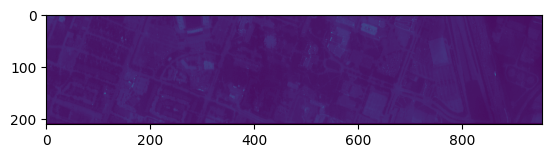

In [43]:
import scipy
from scipy.io import loadmat
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
images = mat73.loadmat('./Houston/Houston13.mat')['ori_data']
imgplot = plt.imshow(images[:,:,0])

plt.show()

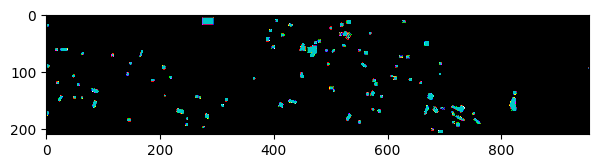

In [44]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

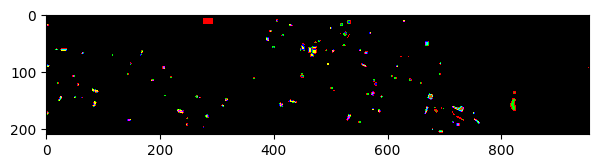

In [45]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [136]:
spectral.save_rgb("predictions2.jpg", outputs.astype(int), colors=spectral.spy_colors)

spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)